<a href="https://colab.research.google.com/github/smwalter96/PUS2020_MWalter/blob/master/HW13/PUS_HW13_Neural_Networks_deepdream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepDreaming with TensorFlow

#modified by FBB (@fedhere) for UD DSPS 2019 class and PUS 2020 class

### ___Alex Mordvintsev___

This notebook produces DeepDream images from user-supplied photos using Google's pretrained Inception neural network. It can be used as a starting point for further exploration in visualizing convolutional neural networks.

###  Load the model graph

The pretrained Inception network can be downloaded [here](https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip). This next cell downloads the file automatically and unpacks it locally to the Colab kernel. We can the load the contained model file  'tensorflow_inception_graph.pb' in the cell below.

In [1]:
!pip install tensorflow==1.12.0


     |████████████████████████████████| 83.1MB 43kB/s 
     |████████████████████████████████| 3.1MB 57.4MB/s 
  Found existing installation: tensorboard 2.1.0
    Uninstalling tensorboard-2.1.0:
      Successfully uninstalled tensorboard-2.1.0
  Found existing installation: tensorflow 2.1.0
    Uninstalling tensorflow-2.1.0:
      Successfully uninstalled tensorflow-2.1.0


In [2]:
!wget -nc --no-check-certificate https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip 
!unzip -n inception5h.zip

from io import BytesIO
from IPython.display import clear_output, Image, display
import numpy as np
import PIL.Image
import tensorflow as tf
import pylab as pl
from __future__ import print_function

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
t_input = tf.placeholder(np.float32, name='input') # define the input tensor
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

--2020-12-08 00:37:37--  https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.240, 172.253.122.128, 172.217.7.144, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49937555 (48M) [application/zip]
Saving to: ‘inception5h.zip’

inception5h.zip     100%[===================>]  47.62M  52.6MB/s    in 0.9s    

2020-12-08 00:37:38 (52.6 MB/s) - ‘inception5h.zip’ saved [49937555/49937555]

Archive:  inception5h.zip
  inflating: imagenet_comp_graph_label_strings.txt  
  inflating: tensorflow_inception_graph.pb  
  inflating: LICENSE                 
Instructions for updating:
Use tf.gfile.GFile.


In [3]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    


# Task 1: Create a random noise "image": an array of 300x300 pixels and 3 color channels (RGB). Fill it in with random noise but make sure the values are Unsigned integer 8bit type (np.unit8) and contained between 0 and 255. This is how a jpg image would be encoded in python and both pylab and this base code require this encoding for the image.  This can be achieved by generating random uniform noise (between 0 and 1) and convert it to 0-255 by multiplication, then convert the data type

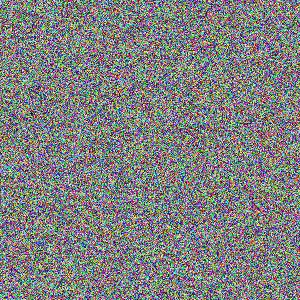

In [ ]:
rnd = np.random.randint(0,256, size=(300,300,3), dtype=np.uint8)

showarray(rnd)


Figure 1: Random noise image generated with numpy.

In [52]:
# These parameters let us control the strenth of the deepdream.
octave_n = 4
octave_scale = 1.4
iter_n = 10
strength = 200

# Helper function that uses TensorFlow to resize an image
def resize(img, new_size):
    return sess.run(tf.image.resize_bilinear(img[np.newaxis,:], new_size))[0]

# Apply gradients to an image in a seires of tiles
def calc_grad_tiled(img, t_grad, tile_size=256):
    '''Random shifts are applied to the image to blur tile boundaries over
    multiple iterations.'''
    h, w = img.shape[:2]
    sx, sy = np.random.randint(tile_size, size=2)
    # We randomly roll the image in x and y to avoid seams between tiles.
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-tile_size//2, tile_size),tile_size):
        for x in range(0, max(w-tile_size//2, tile_size),tile_size):
            sub = img_shift[y:y+tile_size,x:x+tile_size]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+tile_size,x:x+tile_size] = g
    imggrad = np.roll(np.roll(grad, -sx, 1), -sy, 0)
    # Add the image gradient to the image and return the result
    return img + imggrad*(strength * 0.01 / (np.abs(imggrad).mean()+1e-7))

# Applies deepdream at multiple scales
def render_deepdream(t_obj, input_img, show_steps = True):
    # Collapse the optimization objective to a single number (the loss)
    t_score = tf.reduce_mean(t_obj)
    # We need the gradient of the image with respect to the objective
    t_grad = tf.gradients(t_score, t_input)[0]

    # split the image into a number of octaves (laplacian pyramid)
    img = input_img
    octaves = []
    for i in range(octave_n-1):
        lo = resize(img, np.int32(np.float32(img.shape[:2])/octave_scale))
        octaves.append(img-resize(lo, img.shape[:2]))
        img = lo

    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            img = calc_grad_tiled(img, t_grad)
        if show_steps:
            clear_output()
            showarray(img)
    return img

# Task 2 start a deep dream : 

Adjust the sliders to change the strength of the deep dream, and how many scales it is applied over and until you obtain a "phsychadelic" result that you like

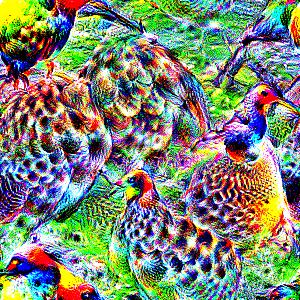

In [ ]:
octave_n = 7 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 45 #@param {type:"slider", max: 50}
strength = 689 #@param {type:"slider", max: 1000}
layer = "mixed5a"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), rnd)


Figure 2: Deep dream image created from the random noise image with the layer called 'mixed5a'. In this image, birds appear to be constructed from the random noise.

 # Task 3 pull each layer: 
 look at the  diagram above that shows the architecture of the layer. Plot each relevant layer: the layers that start with "mixed"  . Plot each one in a for loop using the command 
 ```showarray(render_deepdream(tf.square(T(l)), rnd, show_steps=False))```

 look at the layer one by one (it will take a while to plot) and look at tho more complex structures arise from the noise. Try to describe what is happening (based on your reading and our discussion)

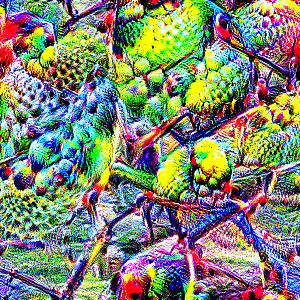

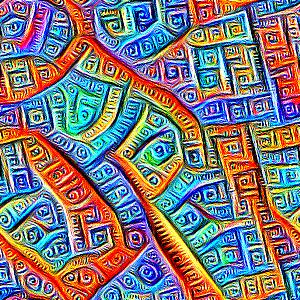

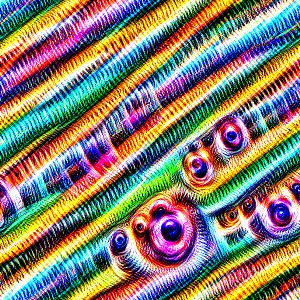

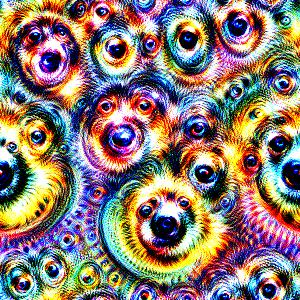

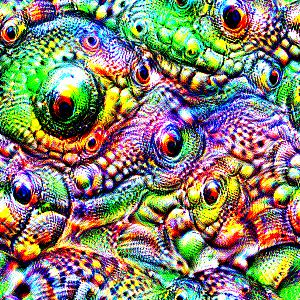

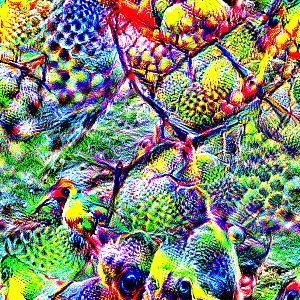

In [ ]:
layer = ("mixed5a", "mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a")
for l in layer:
  showarray(render_deepdream(tf.square(T(l)), rnd, show_steps=False))

Figure 3: Several intermediate deep neural network layers generated from the random noise image. Each layer visualized different shapes and images. The first image appears to show birds, the second defines some shapes, the third again shows some line shapes and a few eyes, the fourth appears to have dog faces, the fifth shows more reptilian features, and the sixth appears to show birds again.

# Task 4:  Qalitatively describe, based on your reading, why the layers show different features and what it the "kind" of features extracted in the earler layers vs the later ones.


Each layer is a representation of the original image after being passed through a neuron in a deep neural network. The neural network works to classify the image as a certain object or animal, it does this by altering the image through many layers of a neural network to enchance certain features of the image. The first layers show low level features such as different lines and patterns within the image. This is why the first layers just show basice shapes instead of anything more complex. However as higher layers are reached, the neurons begin to enhance certain features that represent things it has been trained to classify, such as a dogs face or a bird. This is why deeper layers start showing eyes or other animal features scattered throughout the image, so that it can classify the image between the things it has been trained to detect.

...

# Task 5: Load your chosen image 

In [8]:
from google.colab import files
uploaded = files.upload()

Saving PXL_20201115_132132075.PORTRAIT.jpg to PXL_20201115_132132075.PORTRAIT.jpg


In [9]:

if type(uploaded) is not dict: uploaded = uploaded.files  ## Deal with filedit versions
file_contents = uploaded[uploaded.keys()[0]]

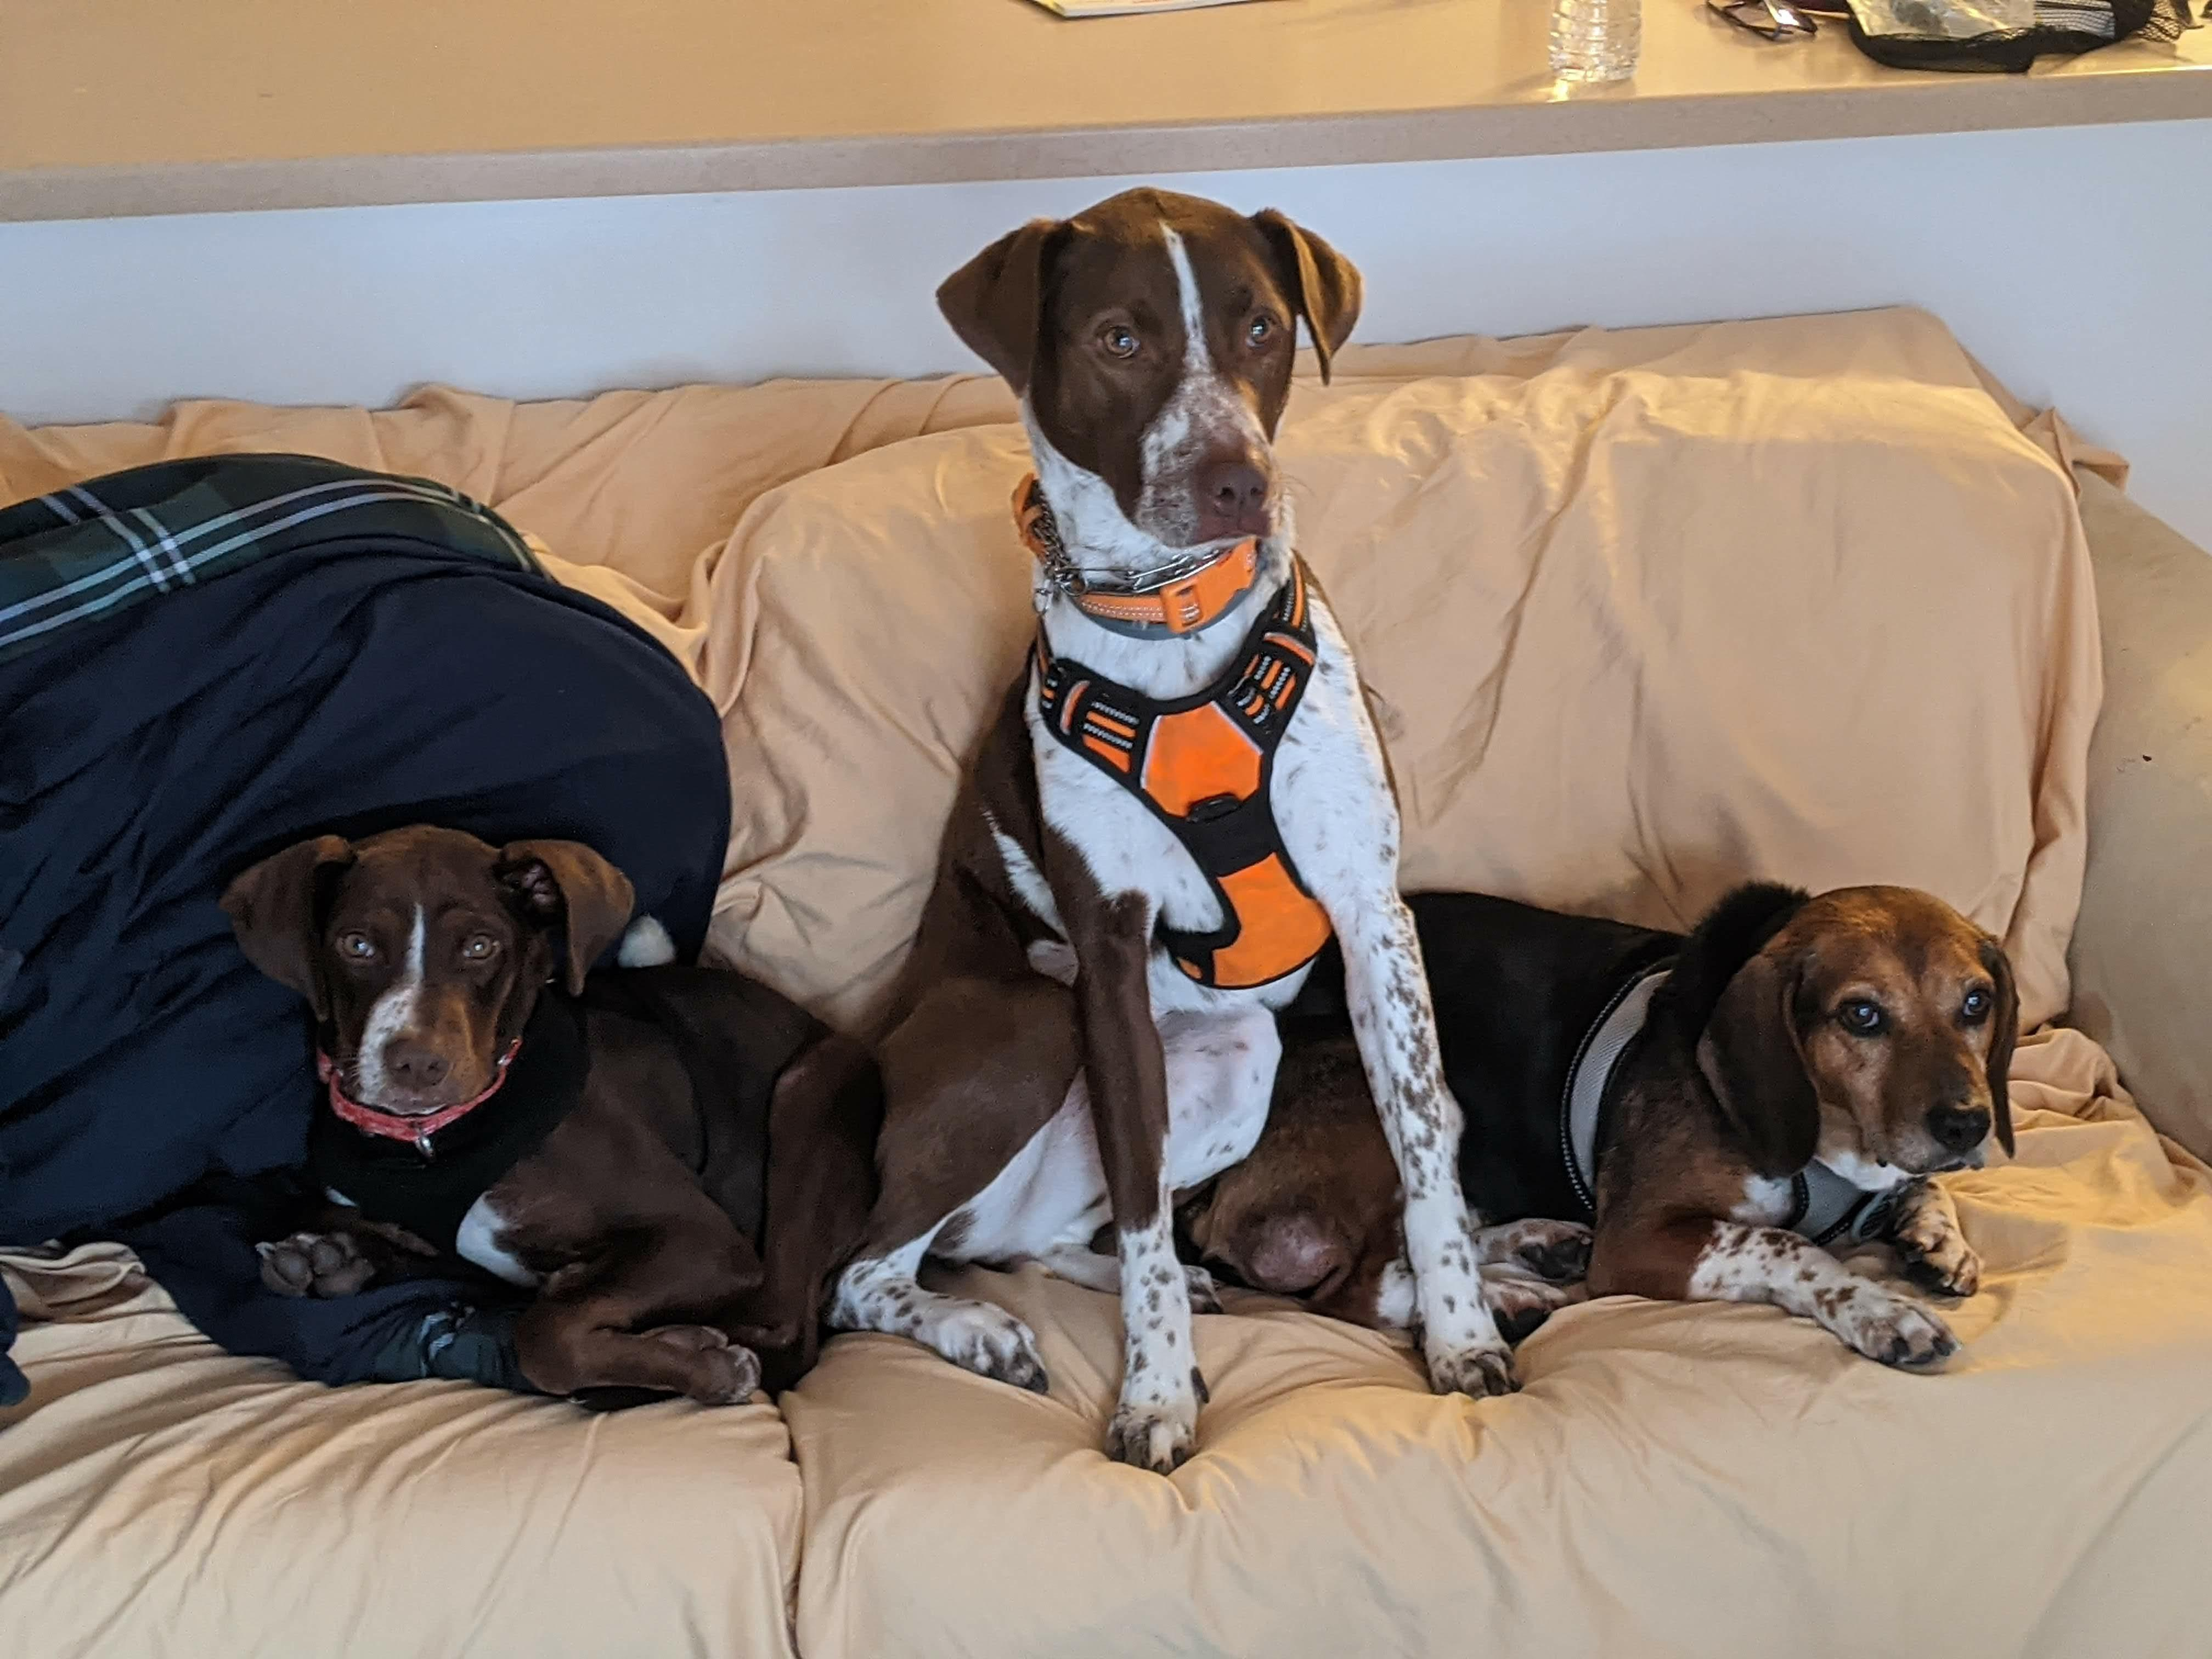

In [10]:
img0 = sess.run(tf.image.decode_image(file_contents))
showarray(img0)


Figure 4: New image of several dogs.

# Task 6: shrink it to 600 pixels along the x axis by subsampling (so it takes less time)


In [48]:
basewidth = 600
stepx = int(float(img0.shape[0] / basewidth))
stepy = int(float(img0.shape[1] / basewidth))

img1= img0.copy()
img1.shape, stepx, stepy



((3024, 4032, 3), 5, 6)

In [49]:
import cv2
img1 = cv2.resize(img1, (img1.shape[1]//stepy, 
                         img1.shape[0]//stepx),
                        interpolation=cv2.INTER_NEAREST)
img1.shape

(604, 672, 3)

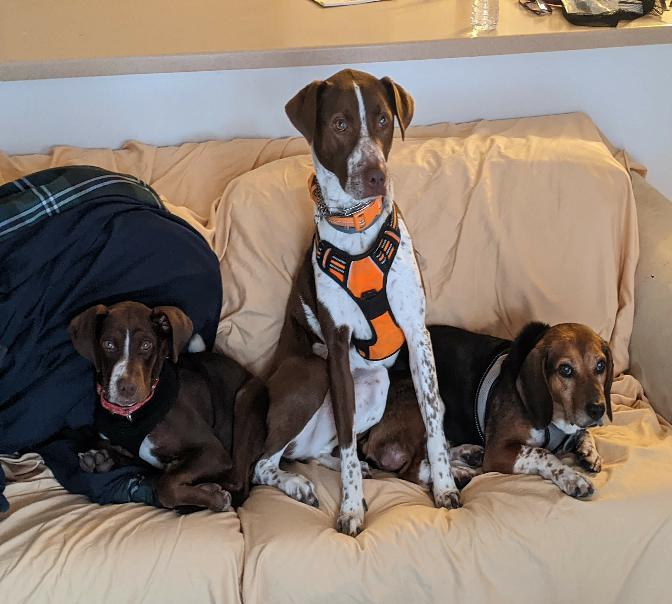

In [50]:
showarray(img1)


Figure 5: Reshaped image of dogs to around 600x600 pixels.

# Task 7: Repeat step 4, DeepDream, with your image. Save the layer you like. Upload tha original and modified image to the readme file of your PUS repo



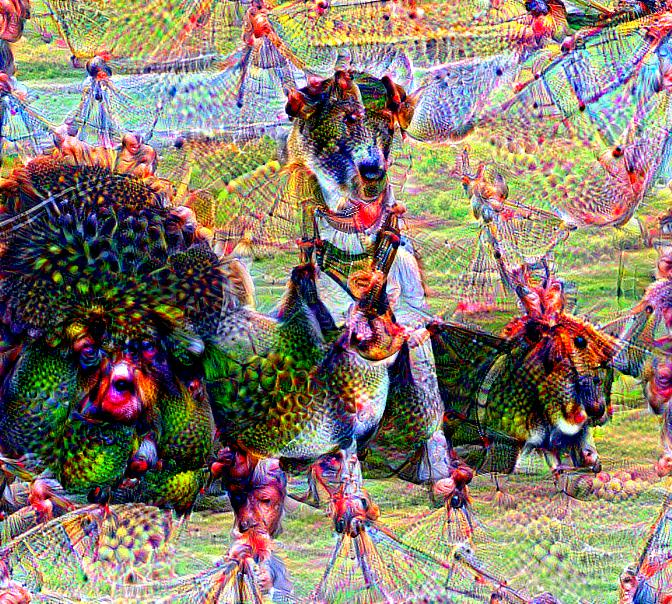

In [58]:
octave_n = 7 #@param {type:"slider", max: 10}
octave_scale = 1.4 #@param {type:"number"}
iter_n = 24 #@param {type:"slider", max: 50}
strength = 494 #@param {type:"slider", max: 1000}
layer = "mixed4c"  #@param ["mixed3a", "mixed3b", "mixed4a", "mixed4c", "mixed5a"]

final = render_deepdream(tf.square(T(layer)), img1)


Figure 6: Layer mixed3b from the neural network using the dog image. Eye shapes appear both where the dogs eyes and noses are and also scattered throughout the image.

# Task 8: Answer: Are there "animals" in your image? why? (there should be)


This image and layer didn't generate any very concrete animals, however there are many features of animals such as eyes, feathers, and scales throughout the image. This is because this specific neural network was trained with images of certain animals. The neural network is trying to enhance certain features that it associates with those training images from the original image in order to classify the image. It tries to enhance these animal features to make the image look more like how the neural network thinks a certain animal should look. This causes parts of animals to be scattered throughout the image.

### Further reading for the curious

 *   Original [DeepDream (Inceptionism) blog post](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html)
 *   [Original DeepDream algorithm](https://github.com/google/deepdream/blob/master/dream.ipynb) with Caffe



Lets look a bit deeper into the Inception Model and visualize the layers. Each layer will produce a very different result when used in deep dreaming.

In [ ]:
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

for layer in layers:
  print('Layer:', layer)

Number of layers 59
Total number of feature channels: 7548
Layer: import/conv2d0_pre_relu/conv
Layer: import/conv2d1_pre_relu/conv
Layer: import/conv2d2_pre_relu/conv
Layer: import/mixed3a_1x1_pre_relu/conv
Layer: import/mixed3a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3a_3x3_pre_relu/conv
Layer: import/mixed3a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3a_5x5_pre_relu/conv
Layer: import/mixed3a_pool_reduce_pre_relu/conv
Layer: import/mixed3b_1x1_pre_relu/conv
Layer: import/mixed3b_3x3_bottleneck_pre_relu/conv
Layer: import/mixed3b_3x3_pre_relu/conv
Layer: import/mixed3b_5x5_bottleneck_pre_relu/conv
Layer: import/mixed3b_5x5_pre_relu/conv
Layer: import/mixed3b_pool_reduce_pre_relu/conv
Layer: import/mixed4a_1x1_pre_relu/conv
Layer: import/mixed4a_3x3_bottleneck_pre_relu/conv
Layer: import/mixed4a_3x3_pre_relu/conv
Layer: import/mixed4a_5x5_bottleneck_pre_relu/conv
Layer: import/mixed4a_5x5_pre_relu/conv
Layer: import/mixed4a_pool_reduce_pre_relu/conv
Layer: import/mixed4b_1

For example try deepdreaming with the layer '`mixed4a_3x3_pre_relu`'

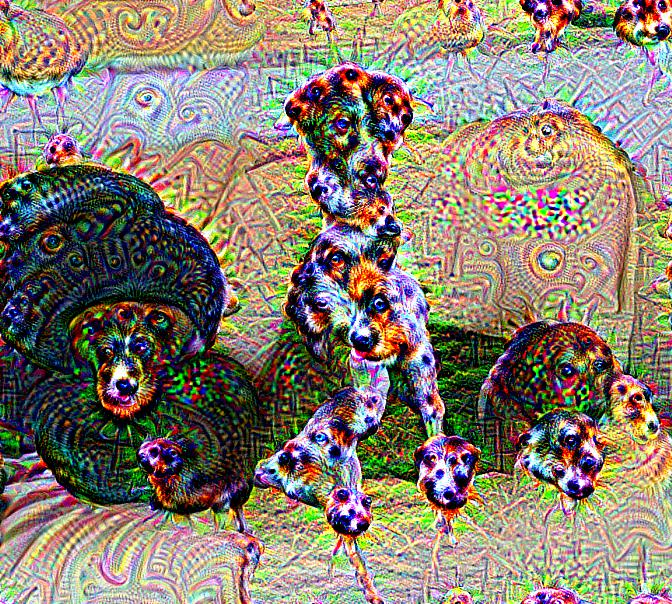

In [56]:
layer = "mixed4b_5x5_bottleneck_pre_relu"
final = render_deepdream(tf.square(T(layer)), img1)

Figure 7: Another neural network layer from the dog image. This image appears to show several dog faces on the bodies of the dogs.

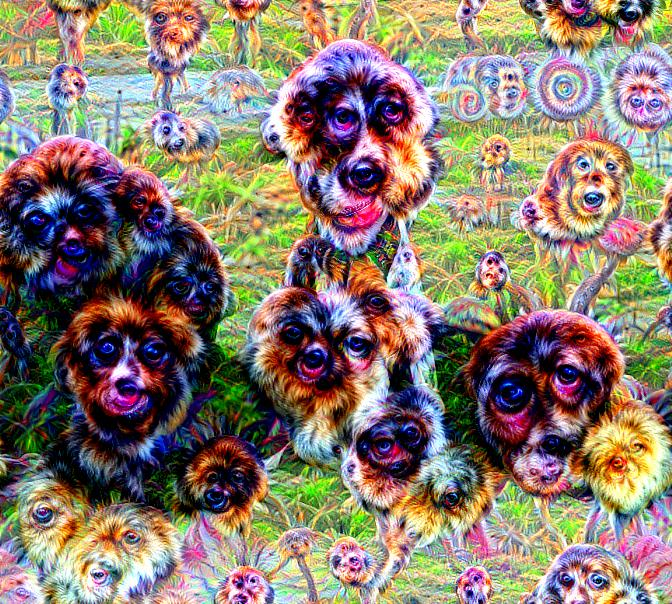

In [59]:
layer = "mixed4b_pool_reduce_pre_relu"
final = render_deepdream(tf.square(T(layer)), img1)

Figure 8: Another layer generated from the same neural network as Figure 7. Dog faces appear on the actual dogs faces as well as throughout the image. This layer of the neural network looks drastically different from that of Figure 7, despite being from the same neural network. This is because each layer of the neural network is detecting and enchancing different aspects and shapes of the image in order to classify the original image.